In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin
from scipy.spatial.distance import cdist

In [3]:
cov = np.array([[0.1, 0], [0, 0.1]])

def point(h, k, r):
    theta = np.random.random() * 2 * pi
    mean = h + cos(theta) * r, k + sin(theta) * r
    p = np.random.multivariate_normal(mean, cov, 1)
    return p

(200, 2)


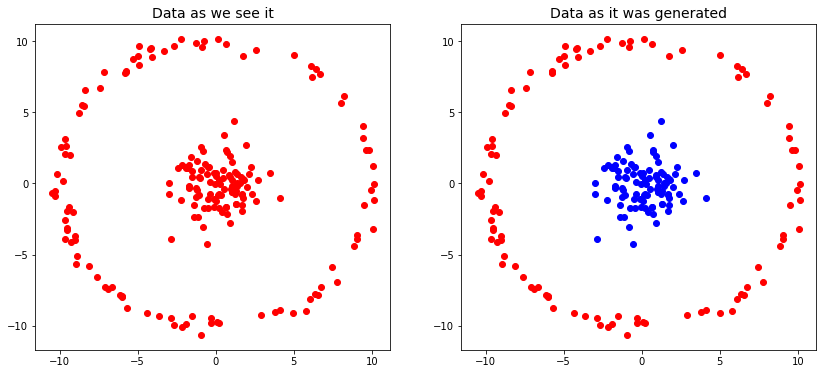

In [4]:
#Create some data
MAXN=100
X = np.array([point(0,0,10)[0] for _ in range(MAXN)])
X = np.concatenate([X, np.random.multivariate_normal([0,0], np.array([[2,0], [0,2]]), MAXN)])
print(X.shape)

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
#y = np.concatenate([np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[[ 0.50155693 -0.60269561]
 [ 0.56278306 -0.79869497]]


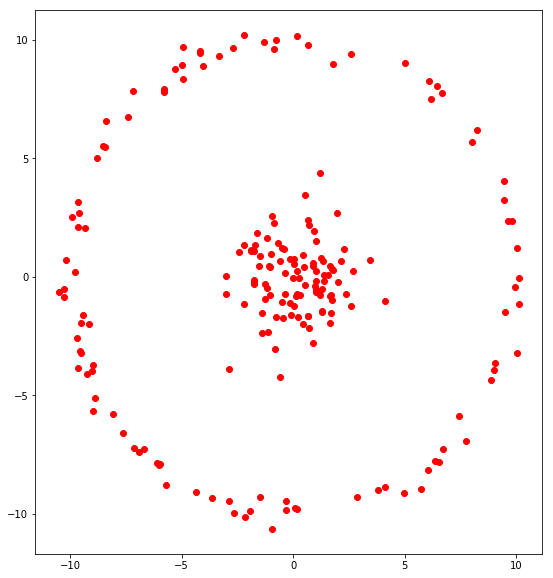

In [5]:
K =2
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print (C)
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((20,10))

In [ ]:
from scipy.stats import multivariate_normal

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in range(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in range(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi

def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in range(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
conv=[]
for iter in range(30):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print (Sigma,Pi)

plt.figure()
plt.plot(conv)
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))